In [ ]:
import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import GPyOpt
import GPy
import os
import matplotlib as mpl
import matplotlib.tri as tri
import ternary
import pickle
import datetime
from collections import Counter
import matplotlib.ticker as ticker
import pyDOE
import random
from sklearn import preprocessing
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
import matplotlib.font_manager as font_manager
import copy
from scipy.interpolate import splrep
from scipy.interpolate import interp1d

In [18]:
dataset_name = 'AutoAM'
raw_dataset = pd.read_csv(dataset_name + '_dataset.csv')
N = len(raw_dataset)
n_top = int(math.ceil(N * 0.05))

In [19]:
test_run_results = np.load('bayesian_optimization_results/test_runRF.npy', allow_pickle = True) 
test_run_results1 = np.load('bayesian_optimization_results/test_run_M52_LCB.npy', allow_pickle = True) 
test_run_results2 = np.load('bayesian_optimization_results/test_run_M32_LCB.npy', allow_pickle = True) 
test_run_results3 = np.load('bayesian_optimization_results/test_run_M12_LCB.npy', allow_pickle = True) 
test_run_results4 = np.load('bayesian_optimization_results/test_run_RBF_LCB.npy', allow_pickle = True) 
test_run_results5 = np.load('bayesian_optimization_results/RF_EI.npy', allow_pickle = True) 
test_run_results6 = np.load('bayesian_optimization_results/RF_PI.npy', allow_pickle = True) 
test_run_results7 = np.load('bayesian_optimization_results/test_run_M52_EI.npy', allow_pickle = True) 
test_run_results8 = np.load('bayesian_optimization_results/test_run_M52_PI.npy', allow_pickle = True) 
Test_AGP = test_run_results[3]
Test_AGP1 = test_run_results1[3]
Test_AGP2 = test_run_results2[3]
Test_AGP3 = test_run_results3[3]
Test_AGP4 = test_run_results4[3]
Test_AGP5 = test_run_results5[3]
Test_AGP6 = test_run_results6[3]
Test_AGP7 = test_run_results7[3]
Test_AGP8 = test_run_results8[3]

In [22]:
# Random baseline
def rand_baseline(nn):
    x_random = np.arange(nn)
    
    M = n_top
    N = nn
    
    P = np.array([None for i in x_random])
    E = np.array([None for i in x_random])
    
    P[0] = M / N
    E[0] = M / N
    
    for i in x_random[1:]:
        P[i] = (M - E[i-1]) / (N - i)
        E[i] = np.sum(P[:(i+1)])
        
    return E / M

# Transfer to percentage
def percentage_(top_count, n_top, N):
    top_percent = [[None for i in np.arange(N)] for i in np.arange(len(top_count))]
    for i in np.arange(len(top_count)):
        for j in np.arange(N):
            top_percent[i][j] = top_count[i][j]/n_top
    return top_percent
    
# Calculate average
def average_(top_percent):
    mean_ = []
    std_ = []
    low_q = []
    high_q = []
    row = []
    for i in np.arange(N):
        for j in np.arange(len(top_percent)):
            row.append(top_percent[j][i])
        mean_.append(np.mean(row))
        std_.append(np.std(row))
        row = []
    sem = np.array(std_)/np.sqrt(len(top_percent))
    low_q = np.array(mean_) - 1.96 * np.array(sem)
    high_q = np.array(mean_) + 1.96 * np.array(sem)
    return np.array(mean_), np.array(low_q), np.array(high_q)


In [23]:
TestPercent_AGP = average_(percentage_(Test_AGP, n_top, N))
TestPercent_AGP2 = average_(percentage_(Test_AGP2, n_top, N))
TestPercent_AGP1 = average_(percentage_(Test_AGP1, n_top, N))
TestPercent_AGP3 = average_(percentage_(Test_AGP3, n_top, N))
TestPercent_AGP4 = average_(percentage_(Test_AGP4, n_top, N))
TestPercent_AGP5 = average_(percentage_(Test_AGP5, n_top, N))
TestPercent_AGP6 = average_(percentage_(Test_AGP6, n_top, N))
TestPercent_AGP7 = average_(percentage_(Test_AGP7, n_top, N))
TestPercent_AGP8 = average_(percentage_(Test_AGP8, n_top, N))

([<matplotlib.axis.YTick at 0x2021d21fca0>,
 [Text(0, 0.0, '0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

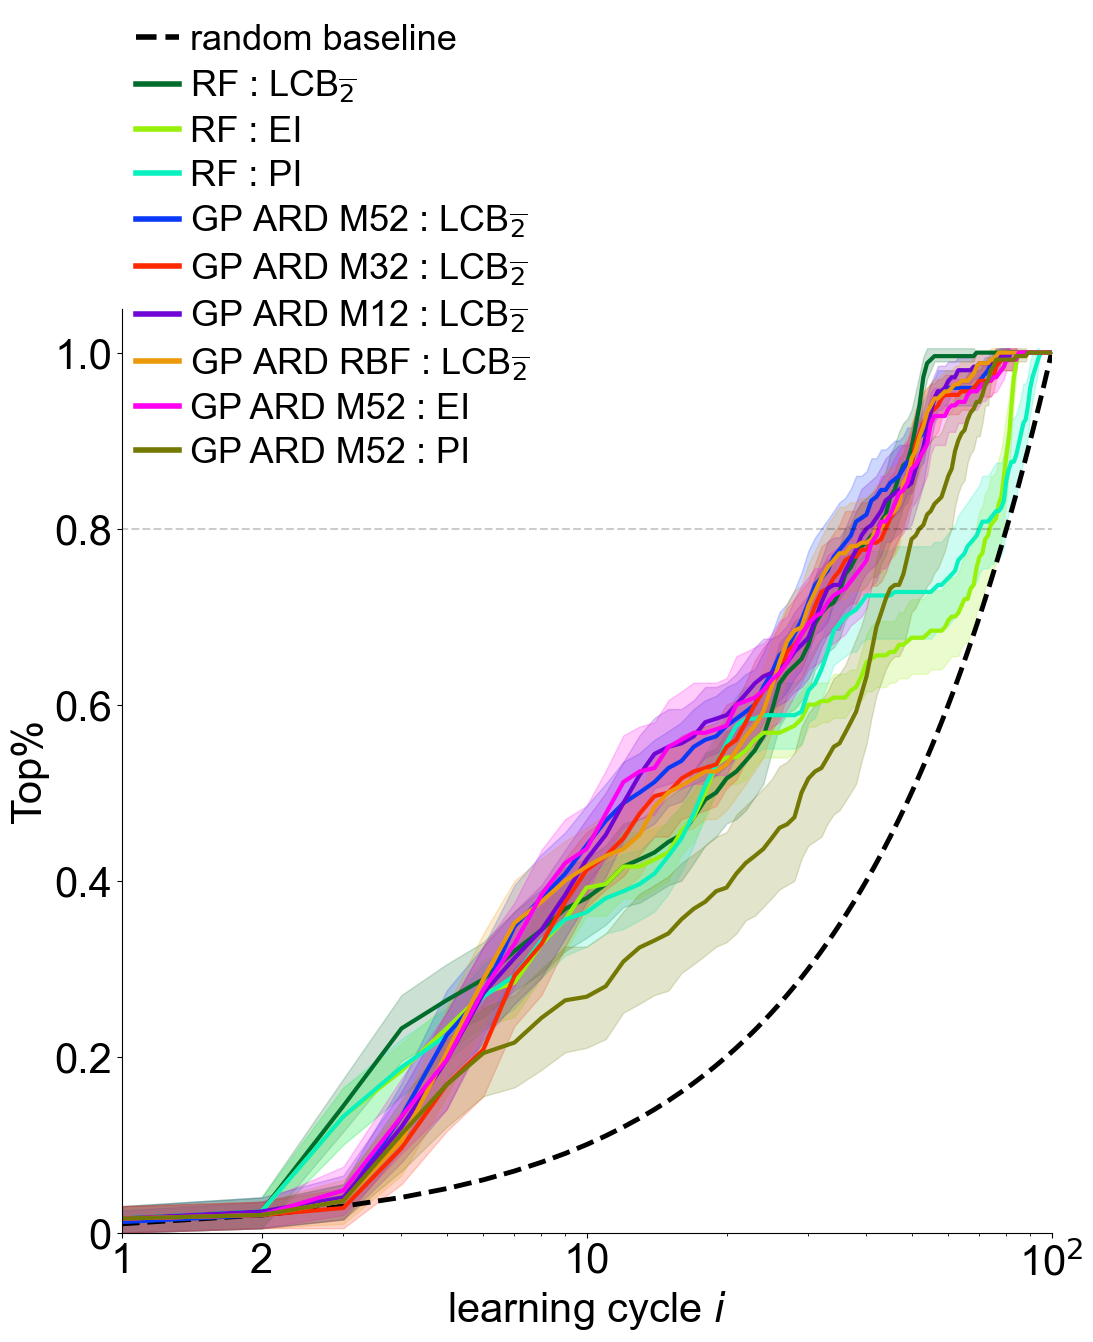

In [24]:
fig = plt.figure(figsize=(12,12))
ax0 = fig.add_subplot(111)

ax0.plot(np.arange(N)+1, rand_baseline(N),'--',color='black',label='random baseline', linewidth=3.5)

ax0.plot(np.arange(N) + 1, TestPercent_AGP[0], label = 'RF : LCB$_{\overline{2}}$', color = '#006d2c', linewidth=3)
ax0.plot(np.arange(N) + 1, TestPercent_AGP5[0], label = 'RF : EI', color = '#98f109', linewidth=3)
ax0.plot(np.arange(N) + 1, TestPercent_AGP6[0], label = 'RF : PI', color = '#09f1be', linewidth=3)
ax0.plot(np.arange(N) + 1, TestPercent_AGP1[0], label = 'GP ARD M52 : LCB$_{\overline{2}}$', color = '#0a3af7', linewidth=3)
ax0.plot(np.arange(N) + 1, TestPercent_AGP2[0], label = 'GP ARD M32 : LCB$_{\overline{2}}$', color = '#ff2900', linewidth=3)
ax0.plot(np.arange(N) + 1, TestPercent_AGP3[0], label = 'GP ARD M12 : LCB$_{\overline{2}}$', color = '#7005d5', linewidth=3)
ax0.plot(np.arange(N) + 1, TestPercent_AGP4[0], label = 'GP ARD RBF : LCB$_{\overline{2}}$', color = '#eb9909', linewidth=3)
ax0.plot(np.arange(N) + 1, TestPercent_AGP7[0], label = 'GP ARD M52 : EI', color = '#ff00f1', linewidth=3)
ax0.plot(np.arange(N) + 1, TestPercent_AGP8[0], label = 'GP ARD M52 : PI', color = '#747904', linewidth=3)

ax0.fill_between(np.arange(N) + 1, np.round(TestPercent_AGP[1].astype(np.double) / 0.005, 0) * 0.005, np.round(TestPercent_AGP[2].astype(np.double) / 0.005, 0) * 0.005, color = '#006d2c', alpha=0.2)
ax0.fill_between(np.arange(N) + 1, np.round(TestPercent_AGP5[1].astype(np.double) / 0.005, 0) * 0.005, np.round(TestPercent_AGP5[2].astype(np.double) / 0.005, 0) * 0.005, color = '#98f109', alpha=0.2)
ax0.fill_between(np.arange(N) + 1, np.round(TestPercent_AGP6[1].astype(np.double) / 0.005, 0) * 0.005, np.round(TestPercent_AGP6[2].astype(np.double) / 0.005, 0) * 0.005, color = '#09f1be', alpha=0.2)
ax0.fill_between(np.arange(N) + 1, np.round(TestPercent_AGP1[1].astype(np.double) / 0.005, 0) * 0.005, np.round(TestPercent_AGP1[2].astype(np.double) / 0.005, 0) * 0.005, color = '#0a3af7', alpha=0.2)
ax0.fill_between(np.arange(N) + 1, np.round(TestPercent_AGP2[1].astype(np.double) / 0.005, 0) * 0.005, np.round(TestPercent_AGP2[2].astype(np.double) / 0.005, 0) * 0.005, color = '#ff2900', alpha=0.2)
ax0.fill_between(np.arange(N) + 1, np.round(TestPercent_AGP3[1].astype(np.double) / 0.005, 0) * 0.005, np.round(TestPercent_AGP3[2].astype(np.double) / 0.005, 0) * 0.005, color = '#7005d5', alpha=0.2)
ax0.fill_between(np.arange(N) + 1, np.round(TestPercent_AGP4[1].astype(np.double) / 0.005, 0) * 0.005, np.round(TestPercent_AGP4[2].astype(np.double) / 0.005, 0) * 0.005, color = '#eb9909', alpha=0.2)
ax0.fill_between(np.arange(N) + 1, np.round(TestPercent_AGP7[1].astype(np.double) / 0.005, 0) * 0.005, np.round(TestPercent_AGP7[2].astype(np.double) / 0.005, 0) * 0.005, color = '#ff00f1', alpha=0.2)
ax0.fill_between(np.arange(N) + 1, np.round(TestPercent_AGP8[1].astype(np.double) / 0.005, 0) * 0.005, np.round(TestPercent_AGP8[2].astype(np.double) / 0.005, 0) * 0.005, color = '#747904', alpha=0.2)

# the rest are for visualization purposes, please adjust for different needs
font = font_manager.FontProperties(family='Arial', size = 26, style='normal')
leg = ax0.legend(prop = font, borderaxespad = 0,  labelspacing = 0.3, handlelength = 1.2, handletextpad = 0.3, frameon=False, loc = (0, 0.81))
for line in leg.get_lines():
    line.set_linewidth(4)
ax0.set_ylabel("Top%", fontname="Arial", fontsize=30, rotation='vertical')    
plt.hlines(0.8, 0, 480, colors='k', linestyles='--', alpha = 0.2)
ax0.set_xlim([1,100])
ax0.set_ylim([0, 1.05])
ax0.set_xscale('log')
ax0.set_xlabel('learning cycle $i$', fontsize=30, fontname = 'Arial')
ax0.xaxis.set_tick_params(labelsize=30)
ax0.yaxis.set_tick_params(labelsize=30)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
plt.xticks([1, 2, 10, 100], ['1', '2','10', '10$^{\mathrm{2}}$'],fontname = 'Arial')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontname = 'Arial')